# Astrometric requirements for strong lensing time-delay cosmography
This notebook accompagnies the paper by Birrer \& Treu 2019, arXiv 1904.10965.
We define the definitions (Equations) in the paper and produce plots and numbers presented in Birrer \& Treu 2019. The lensing computations are performed with $\textit{lenstronomy}$ https://github.com/sibirrer/lenstronomy
and we provide convenient definitions to compute astrometric requirements for different lenses.

Author: Simon Birrer, sibirrer@gmail.com

### import statements
Here we import standard python modules and the lenstronomy modules used

In [1]:
# standard python modules
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

# lenstronomy modules
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.solver import Solver
import lenstronomy.Plots.output_plots as output_plots
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import lenstronomy.Util.constants as const

# set a cosmology for this notebook
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Define routines for astrometric error propagation
In this box, we define the formulae presented in Birrer \& Treu 2019 in functional forms.

In [2]:

# Equation (12)
def sigma_phi_ab(theta_A, theta_B, Sigma_b):
    """
    compute sqrt(variance) of a relative Fermat potential between two images and a source plane error covariance matrix
    theta_A: vector to image A [x, y]
    theta_B: vector to image B [x, y]
    Sigma_b: covariance matrix of the source position uncertainty
    """
    d_ab = theta_A - theta_B
    return np.sqrt(d_ab.T.dot(Sigma_b.dot(d_ab)))


# Equation (13)
def image2source_covariance(A, Sigma_theta):
    """
    computes error covariance in the source plane
    A: Hessian lensing matrix
    Sigma_theta: image plane covariance matrix
    """
    ATSigma = np.matmul(A.T, Sigma_theta)
    return np.matmul(ATSigma, A)


# Equation (15)
def combine_covariances(Sigma_list):
    """
    combine error covariances assuming independence
    param Sigma_list: list of error covariances (2x2 matrices)
    """
    sigma_inv_sum = np.zeros((2, 2))
    for sigma in Sigma_list:
        sigma_inv = inv(sigma)
        sigma_inv_sum += sigma_inv
    return inv(sigma_inv_sum)



## Astrometric requirement estimation routines

In [12]:

# Equation (16)
def h0_shift(theta_AB, t_AB, delta_beta, z_lens, z_source):
    """
    computes the expected shift in h for a given displacement in the source position 
    
    theta_AB: vector between two images in units of arcsec
    t_AB: relative time delay between two images in units days
    delta_beta: vector in shift in the source position in units of arcseconds
    z_lens: redshift of lens
    z_source: redshift of source
    return: expected relative shift in the Hubble constant as calculated from Equation (16)
    """
    lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    sigma_h = 1./(t_AB * const.c * const.day_s) * lensCosmo.D_dt * d_AB * const.arcsec ** 2
    return sigma_h


# Equation (17)
def h0_sigma(theta_AB, t_AB, sigma_astrometry, z_lens, z_source):
    """
    computes the expected uncertainty in h for a given lens and astrometric uncertainty
    
    theta_AB: distance between two images in units of arcsec
    t_AB: relative time delay between two images in units days
    sigma_astrometry: astrometric uncertainty in units of arcseconds
    z_lens: redshift of lens
    z_source: redshift of source
    return: relative error on the Hubble constant as calculated from Equation (17)
    """
    lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    sigma_h = 1./(t_AB * const.c * const.day_s) * lensCosmo.D_dt * const.Mpc * theta_AB * const.arcsec ** 2 
    return sigma_h


# Equation (18)
def astrometry_requirement_dt(theta_AB, dt, z_lens, z_source):
    """
    computes the required astronometric precision to be sub-dominant relative to the
    time delay measurement uncertainty
    
    theta_AB: distance between two images in units of arcsec
    dt: time delay uncertainty in units of days
    z_lens: redshift of lens
    z_source: redshift of source
    return: astrometric requirement (in arcseconds) not to dominate over the time-delay uncertainty
    """
    lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    sigma_astrometry = dt * const.c * const.day_s / (lensCosmo.D_dt * const.Mpc) / const.arcsec ** 2 / theta_AB
    return sigma_astrometry

## Setup calculation for specific lens models
Now we set up the calculation for specific lensmodels and source positions. We use lenstronomy to compute the image positions and the lensing Jacobian to then perform the linear error propagation to determin a combined source position error estimate.

In [4]:

def combined_error_source(lens_model, kwargs_lens, source_x, source_y, sigma_astrometry):
    """
    compute image positions and combine their joint errors in the source plane
    lens_model: lenstronomy LensModel() instance
    kwargs_lens: lenstronomy lens model parameters (see lenstronomy documentations and example notebooks)
    source_x: x-position of source (in arcseconds)
    source_y: y-position of source (in arcseconds)
    sigma_astrometry: astrometric uncertainty (in arcseconds)
    """
    
    # we solve for the image positions for the given choice of lens model and source position
    lensEquationSolver = LensEquationSolver(lensModel=lens_model)
    image_x, image_y = lensEquationSolver.image_position_from_source(source_x, source_y, kwargs_lens, min_distance=0.05, search_window=5,
                                   precision_limit=10**(-10), num_iter_max=100, arrival_time_sort=True,
                                   initial_guess_cut=True, verbose=False, x_center=0, y_center=0)
    # we define the uncorrelated error covariance matrix in the image plane
    Sigma_theta = np.array([[1, 0], [0, 1]]) * sigma_astrometry**2
    Sigma_list = []
    # we loop through the multiple images
    for i in range(len(image_x)):
        # we compute the lensing Jacobian
        f_xx, f_xy, f_yx, f_yy = lens_model.hessian(image_x[i], image_y[i], kwargs_lens)
        A = np.array([[1-f_xx, -f_xy], [-f_yx, 1 - f_yy]])
        # we perform the linear error propagation from the image to the source plane
        Sigma_beta = image2source_covariance(A, Sigma_theta)
        Sigma_list.append(Sigma_beta)
    # we combine the independent error covariances
    Sigma_combined = combine_covariances(Sigma_list)
    return Sigma_combined
        

## Plotting assistance functions
We define some convenient plotting routines to illustrate the effects of the astrometric error propagation.

In [5]:
color_list = ['k', 'k', 'k', 'k']  # list of colors for the ellipses of the images
linestyle_list = [':', '-.', '--', '-'] # list of linestyles for the ellipses of the images
name_list = ['A', 'B', 'C', 'D'] # naming conventions for the images (in increased arrival time)

# make plotting routine of error ellipse
def show_error_contours(ax, lens_model, kwargs_lens, x_pos, y_pos, radius, **kwargs_plot):
    t = np.linspace(0, 2*np.pi, 100)
    x_, y_ = radius * np.cos(t) + x_pos, radius * np.sin(t) + y_pos
    beta_x, beta_y = lens_model.ray_shooting(x_, y_, kwargs_lens)
    ax.plot(beta_x, beta_y, **kwargs_plot)
    return ax

def error_ellipse(ax, xc, yc, Sigma, scale=1, **kwargs):
    '''
    Plot an error ellipse contour over your data.
    https://www.xarg.org/2018/04/how-to-plot-a-covariance-error-ellipse/
    https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
    https://github.com/megbedell/plot_tools/blob/master/error_ellipse.py
    Inputs:
    ax : matplotlib Axes() object
    xc : x-coordinate of ellipse center
    yc : x-coordinate of ellipse center
    Sigma : covariance matrix
    scale: window scaling with Sigma
    additional kwargs passed to matplotlib.patches.Ellipse()
    '''
    w, v = np.linalg.eigh(Sigma) # assumes symmetric matrix
    order = w.argsort()[::-1]
    w, v = w[order], v[:,order]
    theta = np.degrees(np.arctan2(*v[:,0][::-1]))
    ellipse = Ellipse(xy=(xc,yc),
                    width=2.*scale*np.sqrt(w[0]),
                    height=2.*scale*np.sqrt(w[1]),
                    angle=theta, **kwargs)
    #ellipse.set_facecolor('none')
    ax.add_artist(ellipse)
    return ax

# illustrate error ellipses overlapping
def plot_error_ellipse(ax, lens_model, kwargs_lens, source_x, source_y, sigma_astrometry, color_list=None, linestyle_list=None, name_list=None):
    lensEquationSolver = LensEquationSolver(lensModel=lens_model)
    image_x, image_y = lensEquationSolver.image_position_from_source(source_x, source_y, kwargs_lens, min_distance=0.05, search_window=5,
                                       precision_limit=10**(-10), num_iter_max=100, arrival_time_sort=True,
                                       initial_guess_cut=True, verbose=False, x_center=0, y_center=0)



    for i in range(len(image_x)):
        if color_list is not None:
            color=color_list[i]
        else:
            color=None
        if linestyle_list is not None:
            linestyle = linestyle_list[i]
        else:
            linestyle = '-'
        if name_list is not None:
            name = name_list[i]
        else:
            name = None
        ax = show_error_contours(ax, lens_model, kwargs_lens, image_x[i], image_y[i], radius=sigma_astrometry, color=color, linestyle=linestyle, label=name)

    Sigma_combined = combined_error_source(lens_model, kwargs_lens, source_x, source_y, sigma_astrometry)
    ax = error_ellipse(ax, xc=source_x, yc=source_y, Sigma=Sigma_combined, scale=1, ec='red')
    Sigma_theta = np.array([[1, 0], [0, 1]]) * sigma_astrometry**2
    ax = error_ellipse(ax, xc=source_x, yc=source_y, Sigma=Sigma_theta, scale=1, ec='red', alpha=0.05)
    ax.set_xlim([source_x-1.2*sigma_astrometry, source_x + 1.2*sigma_astrometry])
    ax.set_ylim([source_y-1.2*sigma_astrometry, source_y + 1.2*sigma_astrometry])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax


## Example of a cusp, cross and fold lens
We define a lens model consisting of a power-law elliptical mass profile and an external shear component and set three different source positions corresponding to a cusp, cross, and fold configuration. We then plot the image positions and arrival time surfaces and the propagation of the uncertainties in the source plane according to the routines defined above.

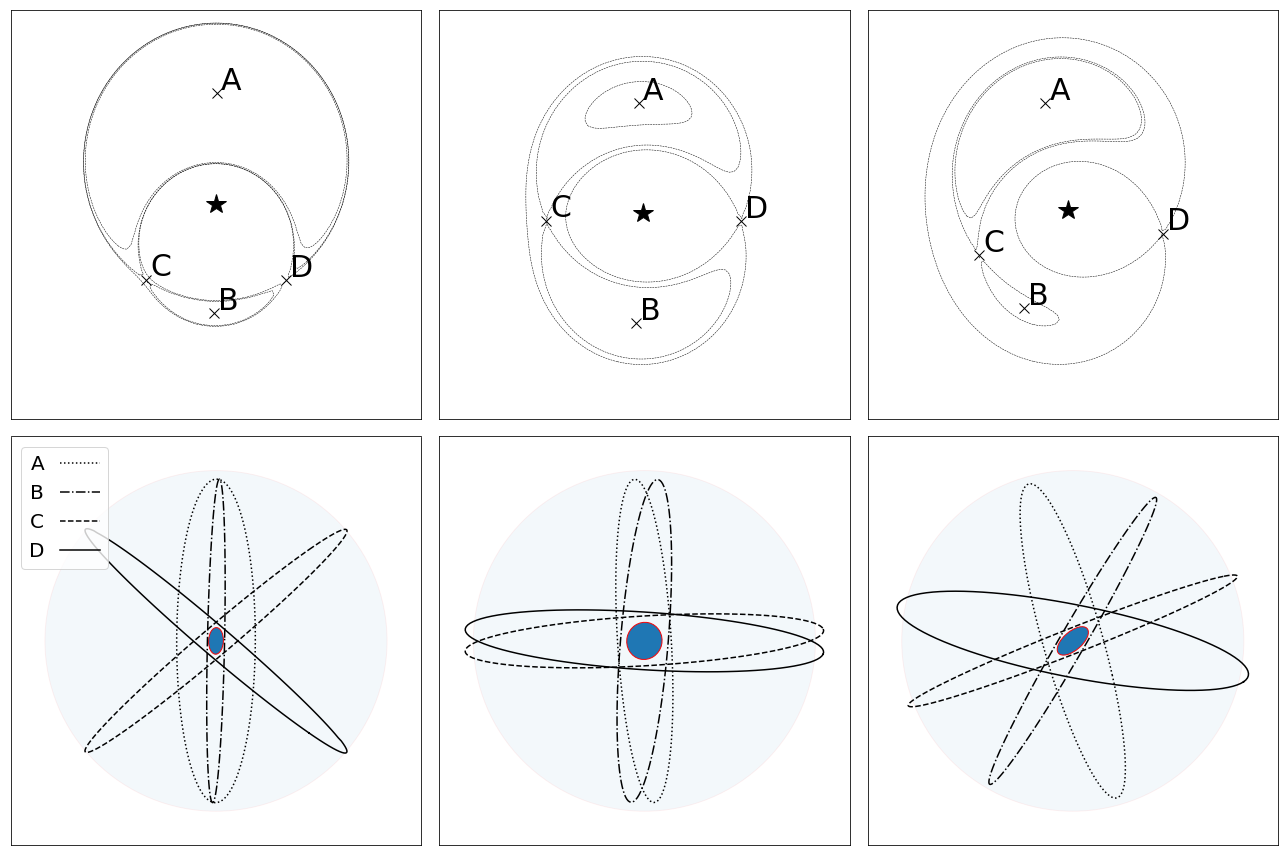

In [6]:
lensModel = LensModel(['SPEMD', 'SHEAR'])
# parameters of the SPEP profile
theta_E = 1.
sigma_astrometry = 0.001
kwargs_spep = {'theta_E': theta_E, 'gamma': 2.0, 'e1': 0.04, 'e2': 0.00, 'center_x': 0, 'center_y':0}
# parameters of the external shear
kwargs_shear = {'e1': -0.05, 'e2': 0.001}
# we patch the two kwargs together to be executed simultaneously by lenstronomy
kwargs_lens = [kwargs_spep, kwargs_shear]
# define a source position
source_x_cusp, source_y_cusp = 0.0*theta_E, 0.10*theta_E
source_x_cross, source_y_cross = -0.01*theta_E, 0.01*theta_E
source_x_fold, source_y_fold = -0.05*theta_E, 0.04*theta_E

kwargs_contour = {'colors': 'k', 'linewidths': 0.5}

with_caustics = False
numPix = 100
f, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=False, sharey=False)

ax = axes[0, 0]
ax = output_plots.arrival_time_surface(ax, lensModel, kwargs_lens, numPix=numPix, 
                                       deltaPix=4*kwargs_spep['theta_E']/numPix, sourcePos_x=source_x_cusp, sourcePos_y=source_y_cusp,
                                         with_caustics=with_caustics, point_source=True, n_levels=20, kwargs_contours=kwargs_contour,
                                       image_color_list=color_list, letter_font_size=30)
ax = axes[1, 0]
ax = plot_error_ellipse(ax, lensModel, kwargs_lens, source_x_cusp, source_y_cusp, sigma_astrometry, 
                        color_list=color_list, linestyle_list=linestyle_list, name_list=name_list)
ax.legend(loc='upper left', fontsize=20, markerfirst=False)

ax = axes[0, 1]
ax = output_plots.arrival_time_surface(ax, lensModel, kwargs_lens, numPix=numPix, 
                                       deltaPix=4*kwargs_spep['theta_E']/numPix, sourcePos_x=source_x_cross, sourcePos_y=source_y_cross,
                                         with_caustics=with_caustics, point_source=True, n_levels=20, kwargs_contours=kwargs_contour, 
                                       image_color_list=color_list, letter_font_size=30)
ax = axes[1, 1]
ax = plot_error_ellipse(ax, lensModel, kwargs_lens, source_x_cross, source_y_cross, sigma_astrometry, color_list=color_list, linestyle_list=linestyle_list)

ax = axes[0, 2]
ax = output_plots.arrival_time_surface(ax, lensModel, kwargs_lens, numPix=numPix, 
                                       deltaPix=4*kwargs_spep['theta_E']/numPix, sourcePos_x=source_x_fold, sourcePos_y=source_y_fold,
                                         with_caustics=with_caustics, point_source=True, n_levels=20, kwargs_contours=kwargs_contour, 
                                       image_color_list=color_list, letter_font_size=30)
ax = axes[1, 2]
ax = plot_error_ellipse(ax, lensModel, kwargs_lens, source_x_fold, source_y_fold, sigma_astrometry, color_list=color_list, linestyle_list=linestyle_list)
f.tight_layout()
plt.show()


## non-linear error propagation
Now we perform the full non-linear error propagation when the image positions do constrain the lens model.

In [7]:
def non_linear_propagation(lens_model, kwargs_lens, image_x, image_y, sigma_astrometry):
    """
    lens_model: lenstronomy LensModel() instance
    kwargs_lens: lenstronomy lens model parameters (see lenstronomy documentations and example notebooks)
    image_x: x-position of images as array (in arcseconds)
    image_y: y-position of images as array (in arcseconds)
    sigma_astrometry: astrometric uncertainty (in arcseconds)
    return: Fermat potentials at displaced image positions with re-fitted lens model, updated source position
    """

    # we randomly displace the image position by the astrometric uncertainty
    delta_x = np.random.normal(loc=0, scale=sigma_astrometry, size=len(image_x))
    delta_y = np.random.normal(loc=0, scale=sigma_astrometry, size=len(image_x))
    image_x_model = image_x + delta_x
    image_y_model = image_y + delta_y
    
    # we solve for a lens model solution of the lens equation for the displaced image positions
    solver = Solver(lensModel=lens_model, num_images=4, solver_type='PROFILE_SHEAR')
    kwargs_solved, tol = solver.constraint_lensmodel(x_pos=image_x_model, y_pos=image_y_model, kwargs_list=kwargs_lens)
    # we ray-trace the displaced positions back into the source plane with the new lens model to compute the source position
    source_x_model, source_y_model = lens_model.ray_shooting(image_x_model, image_y_model, kwargs=kwargs_solved)
    
    # computing of the Fermat potentials of the new lens model at the displaced positions
    phi_model_model_model = lens_model.fermat_potential(x_image=image_x_model, y_image=image_y_model, x_source=source_x_model, y_source=source_y_model, kwargs_lens=kwargs_solved)
    return phi_model_model_model, source_x_model[0], source_y_model[0]
    
def sampling_non_linear(lens_model, kwargs_lens, source_x, source_y, sigma_astrometry, num_samples):
    """
    samples non-linear error propagation
    num_samples: int, number of draws of displaced image positions
    return: 2d numpy array of samples and their Fermat potentials and source position (posteriors)
    """
    lensEquationSolver = LensEquationSolver(lensModel=lens_model)
    image_x, image_y = lensEquationSolver.image_position_from_source(source_x, source_y, kwargs_lens, min_distance=0.05, search_window=5,
                                       precision_limit=10**(-10), num_iter_max=100, arrival_time_sort=True,
                                       initial_guess_cut=True, verbose=False, x_center=0, y_center=0)
    
    samples = np.zeros((num_samples, len(image_x) + 2))
    for i in range(num_samples):
        fermat_pot, source_x, source_y = non_linear_propagation(lens_model, kwargs_lens, image_x, image_y, sigma_astrometry)
        samples[i] = np.append(fermat_pot, np.array([source_x, source_y]))
    return samples


In [23]:
# run the sampling of the non-linear error propagation for one of the lens configurations of the previous section.
sample = sampling_non_linear(lens_model=lensModel, kwargs_lens=kwargs_lens, source_x=source_x_cusp, 
                             source_y=source_y_cusp, sigma_astrometry=sigma_astrometry, num_samples=5000)

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


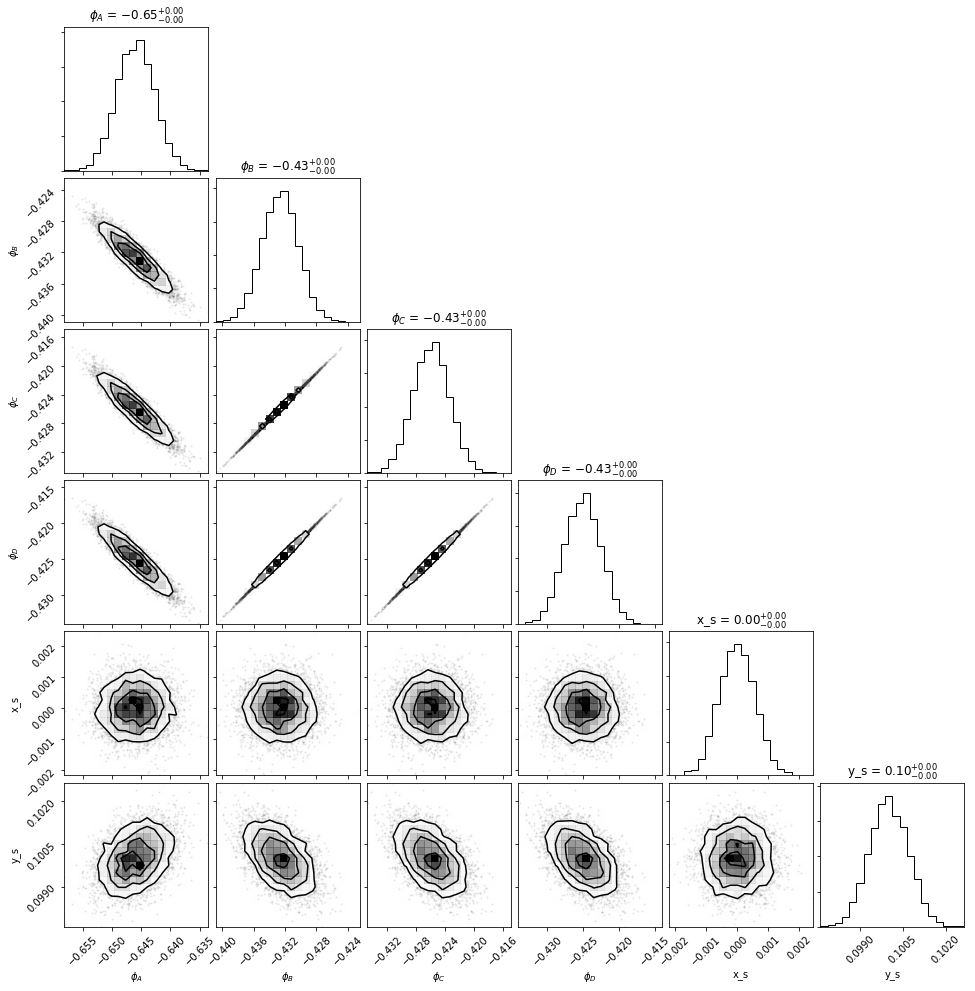

In [24]:
# plot the posterior distribution with the corner package
labels_astrometry = [r'$\phi_A$', r'$\phi_B$', r'$\phi_C$', r'$\phi_D$', 'x_s', 'y_s']
import corner

corner.corner(sample, labels=labels_astrometry, show_titles=True)
plt.show()

## Examples for astrometric requirements
In this plot, we define specific examples and derive the astrometric requirements as presented in Birrer \& Treu 2019 in Table 3.

In [28]:


def print_requirement(example, theta_AB, t_AB, dt, z_lens, z_source, relative_error=0.05, rounding=5, rounding_mas=1):

    sigma_astrometry = astrometry_requirement_dt(theta_AB, dt, z_lens, z_source)
    sigma_relative = astrometry_requirement_dt(theta_AB, t_AB * relative_error, z_lens, z_source)
    print('Example: ' + example)
    print('image separation [arcseconds]: ' + str(round(theta_AB, rounding)))
    print('time delay [days]: ' + str(t_AB))
    print('time delay uncertainty [days]: ', str(round(dt, rounding)))
    print('astrometry to match time-delay precision [mas]: ' + str(round(sigma_astrometry*1000, rounding_mas)))
    print('astrometry to match ' + str(relative_error*100) + ' per cent precision on H0 [mas]: '+ str(round(sigma_relative*1000, rounding_mas)))
    print('===============================')

    
z_lens = 0.5
z_source = 2
relative_error = 0.05


string = 'SN in cluster'
theta_AB = 20
t_AB = 1000
dt = 30
print_requirement(string, theta_AB, t_AB, dt, z_lens, z_source, relative_error)


string = 'H0LiCOW QSO'
theta_AB = 3
t_AB = 100
dt = 3
print_requirement(string, theta_AB, t_AB, dt, z_lens, z_source, relative_error)


string = 'H0LiCOW QSO nearby pair'
theta_AB = 2
t_AB = 10
dt = 1
print_requirement(string, theta_AB, t_AB, dt, z_lens, z_source, relative_error)


string = 'Time Delay Lens Modelling Challenge'
theta_AB = 1
t_AB = 4
dt = 0.25
print_requirement(string, theta_AB, t_AB, dt, z_lens, z_source, relative_error)


string = 'small separation SNa'
theta_AB = 1
t_AB = 1
dt = 0.025
print_requirement(string, theta_AB, t_AB, dt, z_lens, z_source, relative_error)

Example: SN in cluster
image separation [arcseconds]: 20
time delay [days]: 1000
time delay uncertainty [days]:  30
astrometry to match time-delay precision [mas]: 18.0
astrometry to match 5.0 per cent precision on H0 [mas]: 30.0
Example: H0LiCOW QSO
image separation [arcseconds]: 3
time delay [days]: 100
time delay uncertainty [days]:  3
astrometry to match time-delay precision [mas]: 12.0
astrometry to match 5.0 per cent precision on H0 [mas]: 20.0
Example: H0LiCOW QSO nearby pair
image separation [arcseconds]: 2
time delay [days]: 10
time delay uncertainty [days]:  1
astrometry to match time-delay precision [mas]: 6.0
astrometry to match 5.0 per cent precision on H0 [mas]: 3.0
Example: Time Delay Lens Modelling Challenge
image separation [arcseconds]: 1
time delay [days]: 4
time delay uncertainty [days]:  0.25
astrometry to match time-delay precision [mas]: 3.0
astrometry to match 5.0 per cent precision on H0 [mas]: 2.4
Example: small separation SNa
image separation [arcseconds]: 1


## here are some examples from the literature

### SN Refsdal, SX vs S1-4
$ z_d = 0.54 $, 
$ z_s = 1.49 $

$ \Delta t_{AB} = 350\pm 20$ days, $ \theta_{AB} \approx 8 $arcsec

In [41]:
string = 'SN Refsdal, SX vs S1-4'
theta_AB = 8
t_AB = 350
dt = 20
z_d = 0.54
z_s = 1.49

print_requirement(string, theta_AB, t_AB, dt, z_d, z_s, relative_error)


Example: SN Refsdal, SX vs S1-4
image separation [arcseconds]: 8
time delay [days]: 350
time delay uncertainty [days]:  20
astrometry to match time-delay precision [mas]: 23.7
astrometry to match 5.0 per cent precision on H0 [mas]: 20.7


### B1608+656 (Suyu et al. 2010)
$ z_d = 0.6304 $, 
$ z_s = 1.394 $

$ \Delta t_{AB} = 31.5^{+2.0}_{-1.0}$ days, $ \theta_{AB} \approx 1 $arcsec

$ \Delta t_{CB} = 36.0^{+1.5}_{-1.5}$ days, $ \theta_{CB} \approx 2 $arcsec

$ \Delta t_{DB} = 77.0^{+2.0}_{-1.0}$ days, $ \theta_{DB} \approx 3 $arcsec



In [42]:
z_d = 0.6304
z_s = 1.394
dt = 1.5
d_AB, d_CB, d_DB = 1, 2, 3
t_AB, t_CB, t_DB = 31.5, 36, 77
relative_error = 0.05

string = 'AB'
print_requirement(string, d_AB, t_AB, dt, z_d, z_s, relative_error)

string = 'CB'
print_requirement(string, d_CB, t_CB, dt, z_d, z_s, relative_error)

string = 'DB'
print_requirement(string, d_DB, t_DB, dt, z_d, z_s, relative_error)


Example: AB
image separation [arcseconds]: 1
time delay [days]: 31.5
time delay uncertainty [days]:  1.5
astrometry to match time-delay precision [mas]: 10.4
astrometry to match 5.0 per cent precision on H0 [mas]: 11.0
Example: CB
image separation [arcseconds]: 2
time delay [days]: 36
time delay uncertainty [days]:  1.5
astrometry to match time-delay precision [mas]: 5.2
astrometry to match 5.0 per cent precision on H0 [mas]: 6.3
Example: DB
image separation [arcseconds]: 3
time delay [days]: 77
time delay uncertainty [days]:  1.5
astrometry to match time-delay precision [mas]: 3.5
astrometry to match 5.0 per cent precision on H0 [mas]: 8.9


### RXJ1131-1231 (Suyu et al. 2013/2014, Birrer et al 2016)
$ z_d = 0.295 $, 
$ z_s = 0.658 $

$ \Delta t_{AB} = 0.7^{+1.4}_{-1.4}$ days, $ \theta_{AB} \approx 1 $arcsec

$ \Delta t_{CB} = -0.4^{+2}_{-2}$ days, $ \theta_{CB} \approx 2 $arcsec

$ \Delta t_{DB} = 91.4^{+1.5}_{-1.5}$ days, $ \theta_{DB} \approx 3 $arcsec


In [39]:
z_d = 0.295
z_s = 0.658
dt = 1.5
d_AB, d_CB, d_DB = 1, 2, 3
t_AB, t_CB, t_DB = 0.7, 0.5, 91.4
relative_error = 0.05


string = 'AB'
print_requirement(string, d_AB, t_AB, dt, z_d, z_s, relative_error)

string = 'CB'
print_requirement(string, d_CB, t_CB, dt, z_d, z_s, relative_error)

string = 'DB'
print_requirement(string, d_DB, t_DB, dt, z_d, z_s, relative_error)



Example: AB
image separation [arcseconds]: 1
time delay [days]: 0.7
time delay uncertainty [days]:  1.5
astrometry to match time-delay precision [mas]: 23.1
astrometry to match 5.0 per cent precision on H0 [mas]: 0.5
Example: CB
image separation [arcseconds]: 2
time delay [days]: 0.5
time delay uncertainty [days]:  1.5
astrometry to match time-delay precision [mas]: 11.5
astrometry to match 5.0 per cent precision on H0 [mas]: 0.2
Example: DB
image separation [arcseconds]: 3
time delay [days]: 91.4
time delay uncertainty [days]:  1.5
astrometry to match time-delay precision [mas]: 7.7
astrometry to match 5.0 per cent precision on H0 [mas]: 23.4


### HE 0435−1223 (Wong et al. 2017)
$ z_d = 0.4546 $, 
$ z_s = 1.693 $

$ \Delta t_{AB} = -8.8^{+0.8}_{-0.8}$ days, $ \theta_{AB} \approx 1 $arcsec

$ \Delta t_{AC} = -1.1^{+0.7}_{-0.7}$ days, $ \theta_{AC} \approx 2 $arcsec

$ \Delta t_{AD} = -13.8^{+0.9}_{-0.9}$ days, $ \theta_{DB} \approx 1.5 $arcsec

In [37]:
z_d = 0.4546
z_s = 1.693
dt = 0.8
d_AB, d_AC, d_AD = 1, 2, 1.5
t_AB, t_AC, t_AD = 8.8, 1.1, 13.8
relative_error = 0.05


string = 'AB'
print_requirement(string, d_AB, t_AB, dt, z_d, z_s, relative_error)

string = 'AC'
print_requirement(string, d_AC, t_AC, dt, z_d, z_s, relative_error)

string = 'AD'
print_requirement(string, d_AD, t_AD, dt, z_d, z_s, relative_error)


Example: AB
image separation [arcseconds]: 1
time delay [days]: 8.8
time delay uncertainty [days]:  0.8
astrometry to match time-delay precision [mas]: 10.4
astrometry to match 5.0 per cent precision on H0 [mas]: 5.7
Example: AC
image separation [arcseconds]: 2
time delay [days]: 1.1
time delay uncertainty [days]:  0.8
astrometry to match time-delay precision [mas]: 5.2
astrometry to match 5.0 per cent precision on H0 [mas]: 0.4
Example: AD
image separation [arcseconds]: 1.5
time delay [days]: 13.8
time delay uncertainty [days]:  0.8
astrometry to match time-delay precision [mas]: 6.9
astrometry to match 5.0 per cent precision on H0 [mas]: 6.0


### SDSS 1206+4332 (Birrer et al. 2019)
$ z_d = 0.748 $, 
$ z_s = 1.789 $

$ \Delta t_{AB} = 111.3^{+3}_{-3}$ days, $ \theta_{AB} \approx 3 $ arcsec


In [38]:
z_d = 0.748
z_s = 1.789

dt = 3
d_AB = 3
t_AB = 111.3
relative_error = 0.05

string = 'AB'
print_requirement(string, d_AB, t_AB, dt, z_d, z_s, relative_error)

Example: AB
image separation [arcseconds]: 3
time delay [days]: 111.3
time delay uncertainty [days]:  3
astrometry to match time-delay precision [mas]: 6.2
astrometry to match 5.0 per cent precision on H0 [mas]: 11.4
